In [214]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel, StringIndexer, VectorAssembler
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:62046)
Traceback (most recent call last):
  File "C:\Spark_installed\spark-3.0.0-preview2-bin-hadoop2.7\python\lib\py4j-0.10.8.1-src.zip\py4j\java_gateway.py", line 958, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Spark_installed\spark-3.0.0-preview2-bin-hadoop2.7\python\lib\py4j-0.10.8.1-src.zip\py4j\java_gateway.py", line 1096, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:62046)

In [2]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [3]:
# Loading Train data

us_train_cat = spark.read.csv(get_training_filename('USAccident_train_bal_bin.csv'), header = True, inferSchema = True)

In [4]:
# Number of unique labels in Severity column

us_train_cat.agg(countDistinct("Severity")).show()

+---------------+
|count(Severity)|
+---------------+
|              2|
+---------------+



In [5]:
# Checking the balance of data in training dataset

us_train_cat.groupBy('Severity').count().show()

+--------+------+
|Severity| count|
+--------+------+
|       1|258836|
|       0|263700|
+--------+------+



In [6]:
# Loading the test data

us_test_cat = spark.read.csv(get_training_filename('USAccident_validation_new.csv'), header = True, inferSchema = True)

In [7]:
# Checking the balance of data in testing dataset

us_test_cat.groupBy('Severity').count().show()

+--------+------+
|Severity| count|
+--------+------+
|       3| 58617|
|       4|  5993|
|       2|131790|
+--------+------+



In [9]:
# Vector Assembler to convert all features except Severity to a single column features for feeding it to input of model

va = VectorAssembler().setInputCols([i for i in us_train_cat.columns if i!='Severity']).setOutputCol('features')


In [10]:
# String Indexer to assign target Variable Severity name Label needed for the model to predict

label_stringIdx = StringIndexer(inputCol="Severity", outputCol="label")

In [ ]:
# Assigning label of 1 to category 3 and 4 and combine them to make it 1 category for train data

us_train_cat=us_train_cat.withColumn("Severity",when(((us_train_cat["Severity"]==4) | (us_train_cat["Severity"]==3)),1).otherwise(0))

In [11]:
# Assigning label of 1 to category 3 and 4 and combine them to make it 1 category for test data

us_test_cat=us_test_cat.withColumn("Severity",when(((us_test_cat["Severity"]==4) | (us_test_cat["Severity"]==3)),1).otherwise(0))

In [12]:
# Evaluator defined for Binary Classification

evaluator_rfb = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

# RF Base Model

In [14]:

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features",seed=42)

# Pipeline with stages for fitting the training data

rfModel = Pipeline(stages=[label_stringIdx,va, rf])

In [15]:
# Fit the training data using RF pipeline

rf_fit = rfModel.fit(us_train_cat)

In [17]:
# Predict the test data using fitted train pipeline

pred_rfbb = rf_fit.transform(us_test_cat)

In [19]:
# AUC Score for the test data

print("AUC Score is", evaluator_rfb.evaluate(pred_rfbb))

AUC Score is 0.7516960347127739


In [23]:
# Prediction output from the model to pandas

prediction_rfbb=(pred_rfbb).toPandas()["prediction"]

In [24]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [25]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [26]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_rfbb,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.86      0.59      0.70    131790
           1       0.49      0.80      0.61     64610

    accuracy                           0.66    196400
   macro avg       0.68      0.70      0.66    196400
weighted avg       0.74      0.66      0.67    196400



In [27]:
# Feature Importance from RF model 

rf_fit.stages[-1].featureImportances

SparseVector(119, {2: 0.0001, 3: 0.0001, 4: 0.0, 5: 0.0, 7: 0.0, 9: 0.0006, 13: 0.0003, 14: 0.0001, 15: 0.0, 17: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 23: 0.0228, 24: 0.0088, 25: 0.0142, 26: 0.0025, 27: 0.006, 28: 0.0, 30: 0.0268, 32: 0.0003, 34: 0.0164, 36: 0.0976, 38: 0.0, 40: 0.0007, 42: 0.0017, 44: 0.0025, 48: 0.0, 49: 0.0, 50: 0.0014, 51: 0.0508, 52: 0.0274, 53: 0.0, 54: 0.0, 55: 0.0, 58: 0.0001, 59: 0.0, 60: 0.0001, 61: 0.0, 62: 0.0001, 63: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 70: 0.0, 71: 0.0001, 73: 0.0, 75: 0.0001, 77: 0.0, 78: 0.0, 81: 0.1403, 82: 0.0434, 83: 0.0004, 84: 0.0001, 85: 0.0, 87: 0.0, 89: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0112, 97: 0.0, 98: 0.0005, 100: 0.05, 101: 0.0002, 102: 0.0003, 103: 0.0014, 104: 0.0, 105: 0.0209, 106: 0.0001, 107: 0.0121, 109: 0.1052, 110: 0.0, 111: 0.0209, 113: 0.001, 115: 0.0088, 116: 0.013, 117: 0.0, 118: 0.288})

In [28]:
# Creating Pandas Dataframe for Features and their Importance of RF Base Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_rfbb = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], rf_fit.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5, 1.0, 'Top 10 Features based on Importance from Random Forest binary balanced')

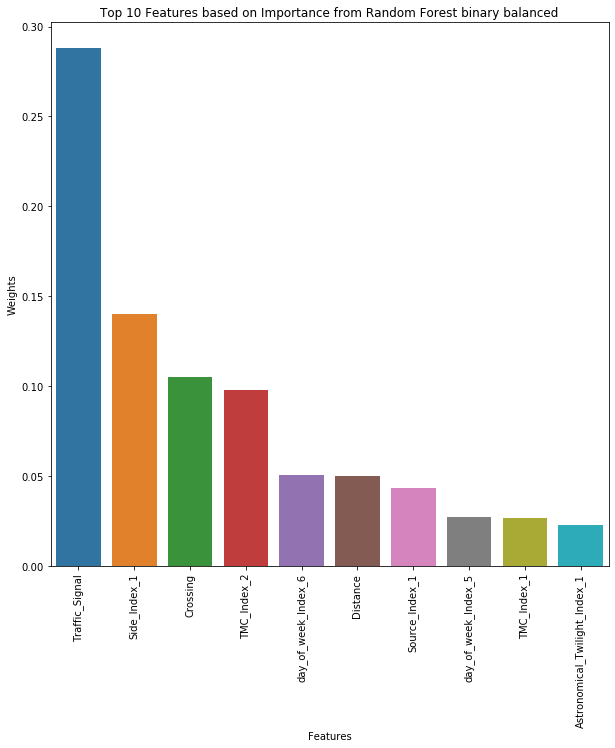

In [29]:
# Plotting top 10 Features from Feature Importance of RF Base Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rfbb['column'][:10], y=feat_imp_tuned_rfbb['weight'][:10],data=feat_imp_tuned_rfbb)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest binary balanced")

In [30]:
# Accuracy calculation for RF Base Model

true_labels=us_test_cat.toPandas()["Severity"]

binary_prediction=(pred_rfbb).select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6618991853360489

# RF Grid Search 

In [210]:

# Create an initial RandomForest model

rf_new = RandomForestClassifier(labelCol="label", featuresCol="features",seed=42)

# Pipeline with stages for RF Grid Search Model

rfModel_new = Pipeline(stages=[label_stringIdx,va, rf_new])

# Grid Search for tuning Hyper parameters 

paramGrid_rft = ParamGridBuilder().addGrid(rf_new.numTrees, [10,25,60]).addGrid(rf_new.maxDepth, [3,6,10]).addGrid(rf_new.impurity,["entropy", "gini"]).build()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:62046)
Traceback (most recent call last):
  File "C:\Spark_installed\spark-3.0.0-preview2-bin-hadoop2.7\python\lib\py4j-0.10.8.1-src.zip\py4j\java_gateway.py", line 1174, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Spark_installed\spark-3.0.0-preview2-bin-hadoop2.7\python\lib\py4j-0.10.8.1-src.zip\py4j\java_gateway.py", line 1014, in send_command
    response = connection.send_command(command)
  File "C:\Spark_installed\spark-3.0.0-preview2-bin-hadoop2.7\python\lib\py4j-0.10.8.1-src.zip\py4j\java_gateway.py", line 1178, in send_command
    "Error while sending", e, proto.ERROR_ON_SEND)
py4j.protocol.Py4JNetworkError: Error while sending

During handling of t

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:62046)

In [209]:
# 5-fold Cross Validator Pipeline and fitting the train data using this cv pipeline

cv_rf = CrossValidator(estimator=rfModel_new, estimatorParamMaps=paramGrid_rft, evaluator=evaluator_rfb, numFolds=5,seed=42).fit(us_train_cat)

Py4JJavaError: An error occurred while calling o124422.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 51187.0 failed 1 times, most recent failure: Lost task 7.0 in stage 51187.0 (TID 368623, DESKTOP-TT8TT9T.fios-router.home, executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.lang.reflect.Array.newArray(Native Method)
	at java.lang.reflect.Array.newInstance(Unknown Source)
	at java.io.ObjectInputStream.readArray(Unknown Source)
	at java.io.ObjectInputStream.readObject0(Unknown Source)
	at java.io.ObjectInputStream.defaultReadFields(Unknown Source)
	at java.io.ObjectInputStream.readSerialData(Unknown Source)
	at java.io.ObjectInputStream.readOrdinaryObject(Unknown Source)
	at java.io.ObjectInputStream.readObject0(Unknown Source)
	at java.io.ObjectInputStream.defaultReadFields(Unknown Source)
	at java.io.ObjectInputStream.readSerialData(Unknown Source)
	at java.io.ObjectInputStream.readOrdinaryObject(Unknown Source)
	at java.io.ObjectInputStream.readObject0(Unknown Source)
	at java.io.ObjectInputStream.readObject(Unknown Source)
	at java.io.ObjectInputStream.readObject(Unknown Source)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:76)
	at org.apache.spark.serializer.DeserializationStream$$anon$1.getNext(Serializer.scala:168)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.maybeCacheDiskValuesInMemory(BlockManager.scala:1516)
	at org.apache.spark.storage.BlockManager.getLocalValues(BlockManager.scala:825)
	at org.apache.spark.storage.BlockManager.get(BlockManager.scala:1111)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1178)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:1989)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1977)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1976)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1976)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:956)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2155)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2144)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:758)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2116)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2137)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2156)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2181)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:737)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:736)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:588)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:226)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:144)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:122)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:48)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:152)
	at sun.reflect.GeneratedMethodAccessor2715.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.lang.reflect.Array.newArray(Native Method)
	at java.lang.reflect.Array.newInstance(Unknown Source)
	at java.io.ObjectInputStream.readArray(Unknown Source)
	at java.io.ObjectInputStream.readObject0(Unknown Source)
	at java.io.ObjectInputStream.defaultReadFields(Unknown Source)
	at java.io.ObjectInputStream.readSerialData(Unknown Source)
	at java.io.ObjectInputStream.readOrdinaryObject(Unknown Source)
	at java.io.ObjectInputStream.readObject0(Unknown Source)
	at java.io.ObjectInputStream.defaultReadFields(Unknown Source)
	at java.io.ObjectInputStream.readSerialData(Unknown Source)
	at java.io.ObjectInputStream.readOrdinaryObject(Unknown Source)
	at java.io.ObjectInputStream.readObject0(Unknown Source)
	at java.io.ObjectInputStream.readObject(Unknown Source)
	at java.io.ObjectInputStream.readObject(Unknown Source)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:76)
	at org.apache.spark.serializer.DeserializationStream$$anon$1.getNext(Serializer.scala:168)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.maybeCacheDiskValuesInMemory(BlockManager.scala:1516)
	at org.apache.spark.storage.BlockManager.getLocalValues(BlockManager.scala:825)
	at org.apache.spark.storage.BlockManager.get(BlockManager.scala:1111)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1178)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Spark_installed\spark-3.0.0-preview2-bin-hadoop2.7\python\lib\py4j-0.10.8.1-src.zip\py4j\java_gateway.py", line 1181, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "C:\Users\hites\Anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Spark_installed\spark-3.0.0-preview2-bin-hadoop2.7\python\lib\py4j-0.10.8.1-src.zip\py4j\java_gateway.py", line 1014, in send_command
    response = connection.send_command(command)
  File "C:\Spark_installed\spark-3.0.0-preview2-bin-hadoop2.7\python\lib\py4j-0.10.8.1-src.zip\py4j\java_gateway.py", line 1193, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.P

In [33]:
# Predicting the test data using fitted cv pipeline

pred_rft = cv_rf.transform(us_test_cat)

In [34]:
# AUC Score of tuned RF model

print("AUC Score is", evaluator_rfb.evaluate(pred_rft))

AUC Score is 0.7819275566312943


In [216]:
# Best Model Hyper Parameters after tuning

cv_rf.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_8713e549bc1f', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='RandomForestClassifier_8713e549bc1f', name='labelCol', doc='label column name.'): 'label',
 Param(parent='RandomForestClassifier_8713e549bc1f', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='RandomForestClassifier_8713e549bc1f', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='RandomForestClassifier_8713e549bc1f', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='RandomForestClassifier_8713e549bc1f', name='seed', doc='random seed.'): 42,
 Param(parent='RandomForestClassifier_8713e549bc1f', name='cacheNodeIds', doc='If false, the algorithm will pa

In [36]:
# Best model number of trees parameter from Grid Search

cv_rf.bestModel.stages[-1].getNumTrees

60

In [38]:
# Accuracy of the model on test data

true_labels=us_test_cat.toPandas()["Severity"]

binary_prediction=pred_rft.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6788441955193483

In [39]:
# Prediction output from the model to pandas

prediction_rft=pred_rft.toPandas()["prediction"]

In [40]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [41]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [42]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_rft,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.87      0.61      0.72    131790
           1       0.51      0.81      0.62     64610

    accuracy                           0.68    196400
   macro avg       0.69      0.71      0.67    196400
weighted avg       0.75      0.68      0.69    196400



In [43]:
# Creating Pandas Dataframe for Features and their Importance of RF Grid Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_rfg = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cv_rf.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5, 1.0, 'Top 10 Features based on Importance from Random Forest Grid')

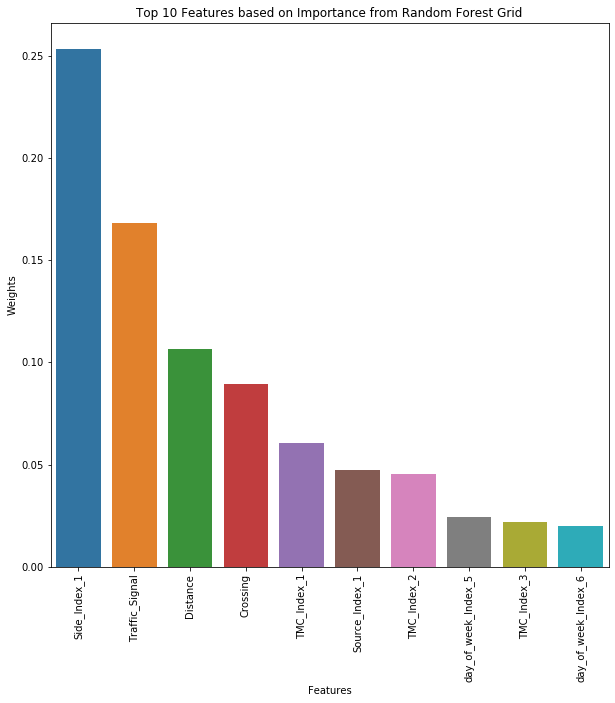

In [44]:
# Plotting top 10 Features from Feature Importance of RF Grid Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rfg['column'][:10], y=feat_imp_tuned_rfg['weight'][:10],data=feat_imp_tuned_rfg)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest Grid")

# GBT Base Model

In [46]:
# Initialize the GBT Base model

gbt = GBTClassifier(seed=42)

In [47]:
# Pipeline with stages to be used to fit the train data

gbt_pipe = Pipeline(stages=[label_stringIdx, va, gbt])

In [48]:
# Fitting the training data using the pipeline above

gbtModel = gbt_pipe.fit(us_train_cat)

In [49]:
# AUC Score from the model on the test data

print("AUC Score is", evaluator_rfb.evaluate(gbtModel.transform(us_test_cat)))

AUC Score is 0.7842374103722184


In [53]:
# Prediction output from the model to pandas

prediction_gbtn=(gbtModel.transform(us_test_cat)).toPandas()["prediction"]

In [54]:
# True labels from the test data for the target variable

true_labels=us_test_cat.toPandas()["Severity"]

In [55]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [56]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_gbtn,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.88      0.60      0.72    131790
           1       0.51      0.83      0.63     64610

    accuracy                           0.68    196400
   macro avg       0.69      0.72      0.67    196400
weighted avg       0.75      0.68      0.69    196400



In [57]:
# Creating Pandas Dataframe for Features and their Importance of GBT Base Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_gtbb = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], gbtModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5, 1.0, 'Top 10 Features based on Importance from GBT Base Model')

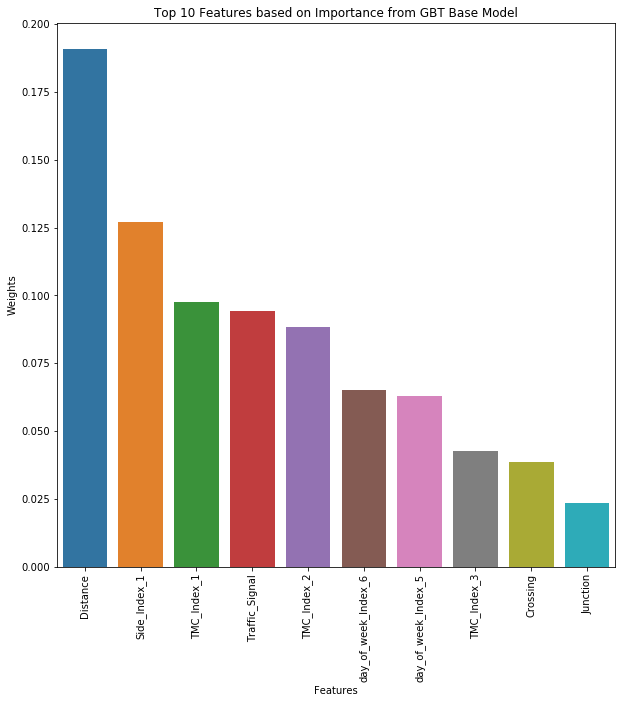

In [58]:
# Plotting top 10 Features from Feature Importance of GBT Base Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_gtbb['column'][:10], y=feat_imp_tuned_gtbb['weight'][:10],data=feat_imp_tuned_gtbb)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from GBT Base Model")

# GBT Binary Classification Grid Search

# GBT Binary Tuned Best Model

In [157]:

# Initializing GBT Grid Pipeline 

gbt_t_new = GBTClassifier(maxIter=55,seed=42)

# Creating pipeline for GBT grid Model 

gbt_pipe_t_new = Pipeline(stages=[label_stringIdx, va, gbt_t_new])

# Binary Classification Evaluator

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

# Creating Grid Search for Hyper Parameter Tuning for GBT model

grid_gbt_t_new = ParamGridBuilder().addGrid(gbt_t_new.stepSize, [0.2,0.4,0.01]).addGrid(gbt_t_new.maxDepth, [3, 5, 8]).build()

# Cross Validator Pipeline with 5 fold cv to fit the training data

cv1_gbt_t_new = CrossValidator(estimator=gbt_pipe_t_new,estimatorParamMaps=grid_gbt_t_new, numFolds=5, evaluator=evaluator,seed=42)

In [158]:
# Fitting train data using 5-fold cross validator pipeline

cvModel_gbt_t_new = cv1_gbt_t_new.fit(us_train_cat)

In [159]:
# AUC Score from the fitted pipeline for the test data

print("AUC Score is", evaluator.evaluate(cvModel_gbt_t_new.transform(us_test_cat)))

AUC Score is 0.8118245222266022


In [173]:
# AUC Score from the Cross validator Pipeline

np.max(cvModel_gbt_t_new.avgMetrics)

0.7997203339021297

In [217]:
# Hyper pramaters from the best model 

cvModel_gbt_t_new.bestModel.stages[-1].extractParamMap()

{Param(parent='GBTClassifier_48357a426a79', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='GBTClassifier_48357a426a79', name='labelCol', doc='label column name.'): 'label',
 Param(parent='GBTClassifier_48357a426a79', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='GBTClassifier_48357a426a79', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='GBTClassifier_48357a426a79', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='GBTClassifier_48357a426a79', name='seed', doc='random seed.'): 42,
 Param(parent='GBTClassifier_48357a426a79', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, t

In [177]:
# Prediction output from the model to pandas

prediction_gbt_t_new=cvModel_gbt_t_new.transform(us_test_cat).toPandas()["prediction"]

In [178]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [179]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [180]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_gbt_t_new,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.88      0.65      0.75    131790
           1       0.53      0.82      0.65     64610

    accuracy                           0.70    196400
   macro avg       0.71      0.73      0.70    196400
weighted avg       0.77      0.70      0.71    196400



In [181]:
# Creating Pandas Dataframe for Features and their Importance of GBT Grid Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_gbt_t_new = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cvModel_gbt_t_new.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5, 1.0, 'Top 10 Features based on Importance from GBT Best tuned')

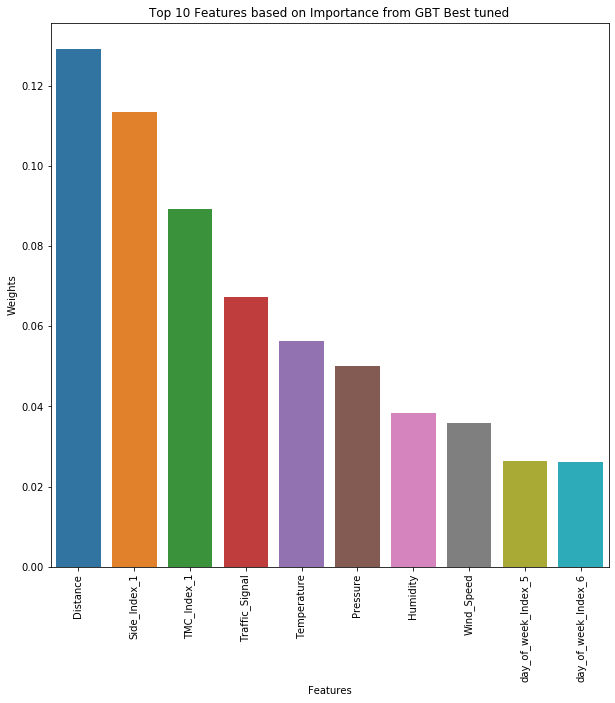

In [182]:
# Plotting top 10 Features from Feature Importance of GBT Grid Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_gbt_t_new['column'][:10], y=feat_imp_tuned_gbt_t_new['weight'][:10],data=feat_imp_tuned_gbt_t_new)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from GBT Best tuned")

# Decision Trees Binary Classification Base Model

In [60]:

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",seed=42)

# Pipeline with stages created for DT Model 

dt_pipe = Pipeline(stages=[label_stringIdx, va, dt])

# Train model with Training Data

dtModel = dt_pipe.fit(us_train_cat)

In [61]:
# Binary Class Evaluator Initialize

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [62]:
# Transform the test data to get prediction from the model for the test data

pred_dt = dtModel.transform(us_test_cat)

In [63]:
# AUC Score from the evaluator for the test data

print("AUC Score is",evaluator.evaluate(pred_dt))

AUC Score is 0.7039599188458128


In [67]:
# Accuracy Calculation for DT Base Model

binary_prediction=pred_dt.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6643584521384929

In [68]:
# Prediction output from the model to pandas

prediction_dtb=pred_dt.toPandas()["prediction"]

In [69]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [70]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [71]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_dtb,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.86      0.60      0.70    131790
           1       0.49      0.81      0.61     64610

    accuracy                           0.66    196400
   macro avg       0.68      0.70      0.66    196400
weighted avg       0.74      0.66      0.67    196400



In [72]:
# Creating Pandas Dataframe for Features and their Importance of DT Base Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_dtb= pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], dtModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5, 1.0, 'Top 10 Features based on Importance from DT Binary Base Model')

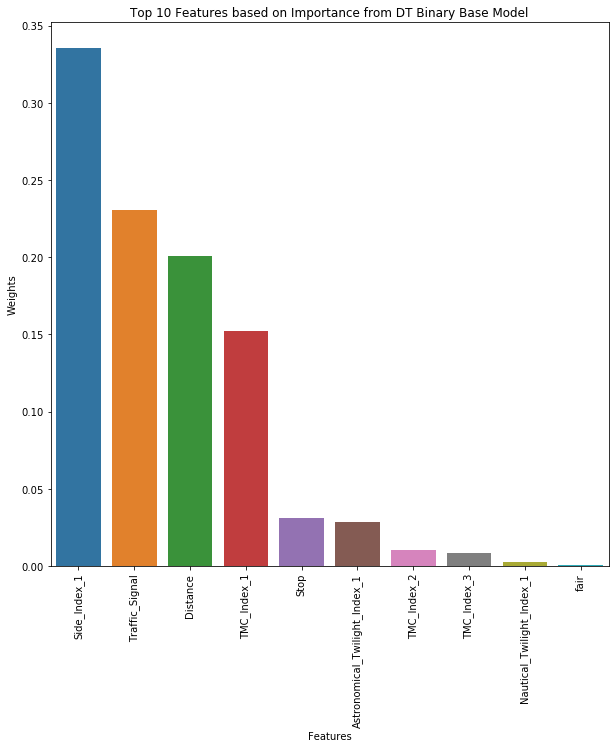

In [73]:
# Plotting top 10 Features from Feature Importance of DT Base Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_dtb['column'][:10], y=feat_imp_tuned_dtb['weight'][:10],data=feat_imp_tuned_dtb)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from DT Binary Base Model")

# Decision Tree Binary Classification Grid Search

In [160]:
# Initializing DT Grid Pipeline

dt_new = DecisionTreeClassifier(labelCol="label", featuresCol="features",seed=42)

# Creating pipeline for DT Grid Model 

dt_new_pipe = Pipeline(stages=[label_stringIdx, va, dt_new])

# Binary Evaluator Initializing

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

# Creating Grid Search for Hyper Parameter Tuning for DT Model

grid_dt = ParamGridBuilder().addGrid(dt_new.maxDepth, [10,15,30]).addGrid(dt_new.minInstancesPerNode, [500,1000,1500]).addGrid(dt_new.maxBins,[20,35,50]).build()

# Cross Validator Pipeline with 5 fold cv to fit the training data

cv1_dt = CrossValidator(estimator=dt_new_pipe,estimatorParamMaps=grid_dt, numFolds=5, evaluator=evaluator,seed=42)

In [161]:
# Fitting the train data using the 5-fold Cross validator pipeline

dtModel_t = cv1_dt.fit(us_train_cat)

In [162]:
# Predicting the test data using the fitted pipeline

pred_dtt = dtModel_t.transform(us_test_cat)

In [163]:
# AUC Score for the fitted pipeline for test data

print("AUC Score", evaluator.evaluate(pred_dtt))

AUC Score 0.6710458592255817


In [218]:
# Best Model Hyper parameters for the DT Grid Search Model

dtModel_t.bestModel.stages[-1].extractParamMap()

{Param(parent='DecisionTreeClassifier_0bccbe6ff0a3', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='DecisionTreeClassifier_0bccbe6ff0a3', name='labelCol', doc='label column name.'): 'label',
 Param(parent='DecisionTreeClassifier_0bccbe6ff0a3', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='DecisionTreeClassifier_0bccbe6ff0a3', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='DecisionTreeClassifier_0bccbe6ff0a3', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='DecisionTreeClassifier_0bccbe6ff0a3', name='seed', doc='random seed.'): 42,
 Param(parent='DecisionTreeClassifier_0bccbe6ff0a3', name='cacheNodeIds', doc='If false, the algorithm will pa

In [167]:
# Prediction output from the model to pandas

prediction_dtbt=pred_dtt.toPandas()["prediction"]

In [168]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [169]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [170]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_dtbt,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.88      0.57      0.70    131790
           1       0.49      0.85      0.62     64610

    accuracy                           0.66    196400
   macro avg       0.69      0.71      0.66    196400
weighted avg       0.76      0.66      0.67    196400



In [171]:
# Creating Pandas Dataframe for Features and their Importance of DT Grid Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_dtbt= pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], dtModel_t.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5, 1.0, 'Top 10 Features based on Importance from DT Binary Grid Model')

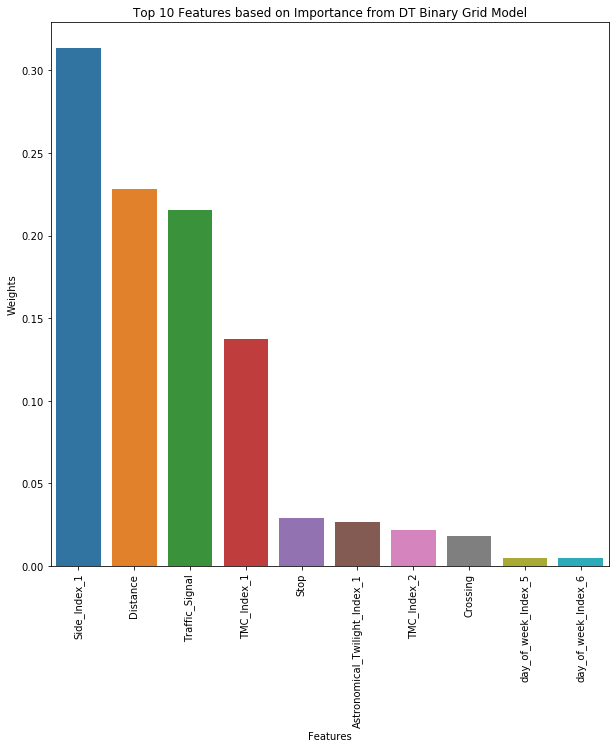

In [172]:
# Plotting top 10 Features from Feature Importance of DT Grid Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_dtbt['column'][:10], y=feat_imp_tuned_dtbt['weight'][:10],data=feat_imp_tuned_dtbt)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from DT Binary Grid Model")

# Logistic Regression 

# Logistic Base Model Binary

In [107]:
# Standard Scaler to standardize the output of vector assembler before feeding it to Logistic Regression

center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

In [109]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="centered_features")

# Pipeline for training data 

lrModel = Pipeline(stages=[label_stringIdx,va, center, lr])

# Fit the train data using LR model

lr_fit = lrModel.fit(us_train_cat)

In [110]:
# Transsform test data to predict Severity by using fitted pipeline from training data

pred_lrb = lr_fit.transform(us_test_cat)

In [111]:
# Evaluator to get AUC Score for test data

evaluator_lrb = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')
print('Test Area Under ROC for Logistic Base Model ', evaluator_lrb.evaluate(lr_fit.transform(us_test_cat)))

Test Area Under ROC for Logistic Base Model  0.7619402091983631


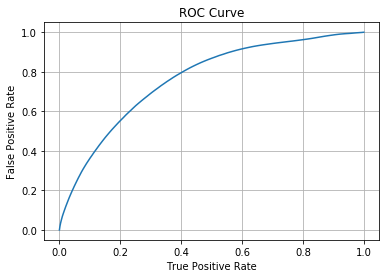

Training set areaUnderROC: 0.7627619042131226


In [112]:
# ROC Curve for LR Base Model

trainingSummary = lr_fit.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [113]:
# Logistic Regression Coefficients to Array 

coef_l1=lr_fit.stages[-1].coefficientMatrix.toArray()

In [114]:
# to stack the coefficient array column wise for further analysis

cof_l1=np.hstack(coef_l1)

In [116]:
# Creating pandas dataframe with Logistic Regression weights for each variable along with variable name

pd.set_option('display.max_rows', None)
feat_imp_tuned_b = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cof_l1)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

In [117]:
# Coefficient from LR model for each variable

coef_L1=lr_fit.stages[-1].coefficients.toArray()

In [146]:
coef_L1

array([ 6.10404226e-02,  3.84503967e-01,  5.55462923e-01,  2.83682423e-02,
        3.11545767e-01,  5.72957889e-01,  2.68684159e-01,  6.40513508e-01,
        2.39662302e-01,  7.29093517e-01,  3.38870399e-01,  6.35365038e-01,
        3.42524554e-01,  3.00627117e-01,  2.86496247e-01,  3.33305131e-01,
        1.74724528e-01,  7.28250150e-01,  4.11683887e-01,  1.01770132e-01,
        7.77776525e-02,  4.80918989e-01,  1.93834032e-01,  6.10964689e-02,
        7.07937460e-02, -2.46781145e-02,  3.25562566e-02,  1.93521868e+00,
        6.98425343e-01,  2.44544359e-01, -2.92797816e-01,  4.20970924e-01,
        1.18834527e+00, -4.98702447e-01,  1.49876162e+00, -3.76084559e-01,
        8.73144768e-01,  1.01459587e+00, -3.68386095e-01,  8.15470313e-01,
        1.02401163e+00,  1.33550551e+00,  9.34355323e-01, -5.02078892e-02,
        1.90952537e+00,  1.15563651e+00,  6.80595337e-01,  5.58708379e-02,
        2.25339626e-02,  2.20958954e-02,  7.43138848e-04,  6.98986882e-01,
        6.92230035e-01,  

In [156]:
# Taking absolute values of weights and calculating the number of features eliminated by LR Model after L1 regularization 

coef_L1 = np.absolute(coef_L1)

print('Total number of features are',len(coef_L1))

sorted_abs = np.sort(coef_L1)

weights_notzero = sorted_abs[sorted_abs == 0]
nonzero_weights = len(sorted_abs[sorted_abs == 0])

print('Eliminated features out of ' + str(len(coef_L1)) + ' are', nonzero_weights)


Total number of features are 119
Eliminated features out of 119 are 0


In [140]:
# Prediction output from the model to pandas

prediction_lrbal=pred_lrb.toPandas()["prediction"]

In [141]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [142]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [143]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_lrbal,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.85      0.63      0.72    131790
           1       0.50      0.77      0.61     64610

    accuracy                           0.67    196400
   macro avg       0.67      0.70      0.66    196400
weighted avg       0.73      0.67      0.68    196400



# Logistic Binary Grid Search Binary

In [183]:
# Logistic Regression Pipeline initialization

lr_new = LogisticRegression(labelCol="label", featuresCol="centered_features")

In [187]:
# Grid Search for tuning the hyper parameters of Logistic Regression Model

paramGrid_lr = ParamGridBuilder().addGrid(lr_new.regParam, [0.01, 0.04,0.07]).addGrid(lr_new.elasticNetParam, [0.1,0.4,0.7]).build()

In [185]:
# Creating pipeline to be used for fitting the training data

cvModel_lrbal = Pipeline(stages=[label_stringIdx,va,center,lr_new])

In [186]:
# Initializing Binary Evaluator for evaluating the model performance

evaluator_lrbt = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [188]:
# Cross validator pipeline initialization for 5-fold cross validation and fitting the train data

cv_lrbal = CrossValidator(estimator=cvModel_lrbal, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_lrbt, numFolds=5,seed=42).fit(us_train_cat)

In [189]:
# Testing the test data on fitted 5 fold cv pipeline

pred_lrbalt=cv_lrbal.transform(us_test_cat)

In [190]:
# Accuracy calculation from the Multiclass evaluator

print("AUC Score is",evaluator_lrbt.evaluate(pred_lrbalt))

AUC Score is 0.7612376191461516


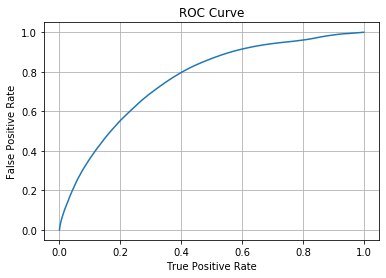

Training set areaUnderROC: 0.7622374995379829


In [191]:
# ROC Curve for Logistic Regression Grid Search Model

trainingSummary_t = cv_lrbal.bestModel.stages[-1].summary
roc = trainingSummary_t.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary_t.areaUnderROC))

In [212]:
# Best Model Hyper parameters after Tuning LR Model

cv_lrbal.bestModel.stages[-1].extractParamMap()

{Param(parent='LogisticRegression_f000cca535b6', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_f000cca535b6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1,
 Param(parent='LogisticRegression_f000cca535b6', name='featuresCol', doc='features column name.'): 'centered_features',
 Param(parent='LogisticRegression_f000cca535b6', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_f000cca535b6', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_f000cca535b6', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='LogisticRegression_f000cca535b6', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimat

In [194]:
# Accuracy Calculation for the test data from the model

binary_prediction=pred_lrbalt.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6688034623217922

In [195]:
# Prediction output from the model to pandas

prediction_lrbalt=pred_lrbalt.toPandas()["prediction"]

In [196]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [197]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [198]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_dtbalt,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.85      0.61      0.71    131790
           1       0.50      0.78      0.61     64610

    accuracy                           0.67    196400
   macro avg       0.67      0.70      0.66    196400
weighted avg       0.74      0.67      0.68    196400



In [199]:
# Coefficient from LR model for each variable

coef_L1_m=cv_lrbal.bestModel.stages[-1].coefficients.toArray()

In [200]:
coef_L1_m

array([-0.05730593,  0.1631614 ,  0.22683363, -0.0922915 ,  0.12743824,
        0.22850115,  0.0874906 ,  0.29489116,  0.        ,  0.37672293,
        0.15445802,  0.28753523,  0.14824354,  0.00970946,  0.10372804,
        0.08653566,  0.        ,  0.37548958,  0.13350159, -0.01698079,
       -0.04548731,  0.17180723,  0.01903713,  0.10730425,  0.08693924,
        0.01656798,  0.06626178,  1.65740542,  0.5776856 ,  0.        ,
       -0.25852766,  0.34445895,  0.99689203, -0.21432981,  1.33791048,
        0.        ,  0.80841273,  0.59158904, -0.23910861,  0.58651763,
        0.90778268,  0.11721702,  0.81946075,  0.        ,  1.58545586,
        0.78832342,  0.50243283,  0.0249303 ,  0.        ,  0.        ,
       -0.01444565,  0.63605211,  0.62860006,  0.22391409,  0.02995857,
       -0.11490668,  0.14692048,  0.        ,  0.02469895, -0.06192017,
        0.        ,  0.10814645,  0.23145346,  0.13481408,  0.03663532,
        0.        ,  0.        , -0.03897284,  0.        ,  0.  

In [205]:
# Pandas dataframe of weights of variables with variable names to find which variables are eliminated

feat_imp_tuned_lrt = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], np.absolute(coef_L1_m))),
            columns = ['column', 'weight']).sort_values('weight')

In [211]:
# Sample of 10 features eliminated by the Logistic Regression Model after L1 Regularization

feat_imp_tuned_lrt[:10]

,column,weight
80,Wind_Direction_Index_12,0.0
65,Wind_Direction_Index_7,0.0
85,clear,0.0
84,cloud,0.0
57,month_of_year_Index_11,0.0
29,TMC_Index_18,0.0
77,Wind_Direction_Index_5,0.0
76,Wind_Direction_Index_15,0.0
75,Wind_Direction_Index_6,0.0
74,Wind_Direction_Index_13,0.0


In [207]:
# Taking absolute values of weights and calculating the number of features eliminated by LR Model after L1 regularization 

coef_L1_m = np.absolute(coef_L1_m)

print('Total number of features are',len(coef_L1_m))

sorted_abs = np.sort(coef_L1_m)

weights_notzero = sorted_abs[sorted_abs == 0]
nonzero_weights = len(sorted_abs[sorted_abs == 0])

print('Eliminated features out of ' + str(len(coef_L1_m)) + ' are', len(weights_notzero))

Total number of features are 119
Eliminated features out of 119 are 28
